In [ ]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns
from collections import defaultdict

In [259]:
data_fama_french = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3.csv', skiprows=3)
data_stocks = pd.read_csv('data/characteristics_data_feb2017.csv')

In [260]:
data_fama_french['Date'] = pd.to_datetime(data_fama_french['Date'], format='%Y%m')
data_fama_french = data_fama_french.set_index('Date')

# data_fama_french[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] /= 100
# leaving the data in percentage format to reduce float precision errors

data_fama_french

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
2024-08-01,1.61,-3.65,-1.13,0.85,0.86,0.48
2024-09-01,1.74,-1.02,-2.59,0.04,-0.26,0.40
2024-10-01,-0.97,-0.88,0.89,-1.38,1.03,0.39


In [261]:
data_stocks.drop(
    columns=[
        "idx",
        "q10",
        "q20",
        "q50",
        "prc",
        "a2me",
        "ato",
        "beme",
        "c",
        "cto",
        "d2a",
        "dpi2a",
        "e2p",
        "fc2y",
        "free_cf",
        "investment",
        "lturnover",
        "noa",
        "oa",
        "ol",
        "pcm",
        "pm",
        "prof",
        "q",
        "rna",
        "roa",
        "roe",
        "s2p",
        "sga2m",
        "at",
        "cum_return_12_2",
        "cum_return_12_7",
        "cum_return_1_0",
        "cum_return_36_13",
        "idio_vol",
        "spread_mean",
        "suv",
        "rel_to_high_price",
        "lev",
    ],
    inplace=True,
)

data_stocks.sort_values(by=["date"], ascending=[True], inplace=True)
data_stocks["date"] = pd.to_datetime(data_stocks["date"])
data_stocks.head()

,yy,mm,date,permno,ret,lme,beta
214585,1962,7,1962-07-31,19940,-0.010899,395763.625,0.599815
286044,1962,7,1962-07-31,25160,-0.039216,39780.000,0.835357
290255,1962,7,1962-07-31,25478,-0.056452,61984.500,-0.012614
214586,1962,8,1962-08-31,19940,0.104683,389952.750,0.581311
286045,1962,8,1962-08-31,25160,0.027211,38220.000,0.794090


Nauči model na svih 6 parametara iz Fama-French podataka po cijeloj povijesti.
Vidi jesu li bolja 2, 3 ili 4 stanja
Full covar
GaussianHMM

In [262]:
# X = data_fama_french.values.reshape(-1, 1)
# lengths = [len(data_fama_french)] * 6

# multivaraite time series
X = data_fama_french.values
lengths = [len(data_fama_french)]

In [263]:
rs = check_random_state(42)
# TODO add K-means initialization
aic = []
bic = []
lls = []
convergence_status = []
iterations = []
ns = [2, 3, 4, 5]


for n in ns:
    best_ll = None
    best_model = None
    for _ in range(30):
        h = GaussianHMM(n, n_iter=2000, tol=1e-6, random_state=rs, covariance_type='full')
        h.fit(X, lengths)
        # TODO add out of sample validation, currently in sample
        score = h.score(X)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = h
        

    aic.append(best_model.aic(X))
    bic.append(best_model.bic(X))
    lls.append(best_model.score(X))
    convergence_status.append(best_model.monitor_.converged)
    iterations.append(best_model.monitor_.iter)


print("Convergence Status: ", convergence_status)
print("Iterations: ", iterations)

Model is not converging.  Current: -8231.26335395783 is not greater than -8231.263352641246. Delta is -1.3165827112970874e-06
Model is not converging.  Current: -7875.941445130761 is not greater than -7875.94142480825. Delta is -2.0322510863479692e-05
Model is not converging.  Current: -7875.941439185904 is not greater than -7875.9414223982085. Delta is -1.678769513091538e-05
Model is not converging.  Current: -7875.941439001635 is not greater than -7875.941422423394. Delta is -1.657824122958118e-05
Model is not converging.  Current: -7887.633960318961 is not greater than -7887.633898400582. Delta is -6.191837837832281e-05
Model is not converging.  Current: -7887.633937372553 is not greater than -7887.633894789578. Delta is -4.2582974856486544e-05
Model is not converging.  Current: -7887.633928996635 is not greater than -7887.633886369665. Delta is -4.262697075319011e-05
Model is not converging.  Current: -7887.633935656747 is not greater than -7887.633888131758. Delta is -4.7524988985

Convergence Status:  [True, True, True, True]
Iterations:  [17, 55, 169, 56]


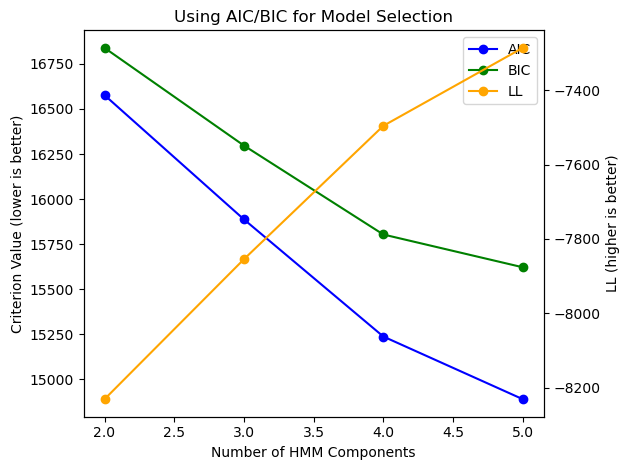

In [264]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

# TODO add heuristic to choose optimal number of components, currently visually finding the elbow

Zaključujemo da je 4 optimalan broj stanja

In [271]:
h = GaussianHMM(n_components=4, n_iter=10000, tol=1e-4, covariance_type='full', random_state=rs)
h.fit(X, lengths=len(X))

hidden_states = h.predict(X, lengths=len(X))

In [272]:
# remap hidden states to be in increasing order of covariance
cov_traces = [np.trace(c) for c in h.covars_]
sorted_indices = np.argsort(cov_traces)

h.means_ = h.means_[sorted_indices]
h.covars_ = h.covars_[sorted_indices]
h.transmat_ = h.transmat_[sorted_indices, :][:, sorted_indices]
h.startprob_ = h.startprob_[sorted_indices]

state_mapping = {old: new for new, old in enumerate(sorted_indices)}
hidden_states = np.vectorize(state_mapping.get)(hidden_states)

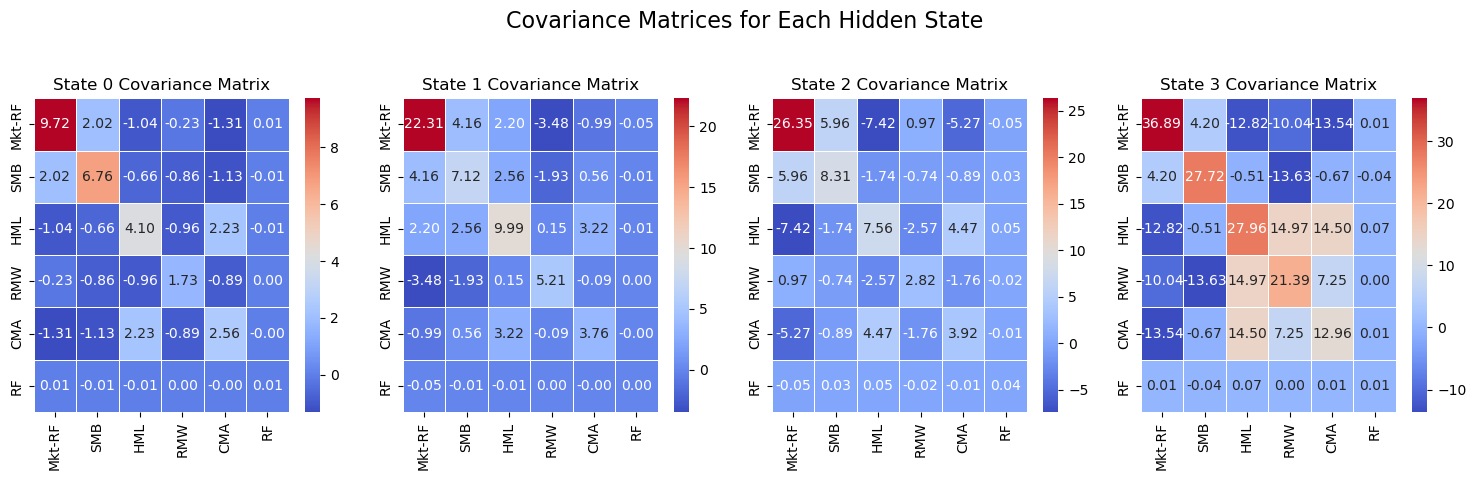

In [273]:
covariance_matrices = h.covars_

factor_names = data_fama_french.columns.tolist()

num_states = len(covariance_matrices)
fig, axes = plt.subplots(1, num_states, figsize=(15, 5))

for i in range(num_states):
    cov_matrix = covariance_matrices[i]

    sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[i],
                xticklabels=factor_names, yticklabels=factor_names)
    axes[i].set_title(f'State {i} Covariance Matrix')

plt.suptitle('Covariance Matrices for Each Hidden State', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [274]:
# calculate the average length of each state
state_lengths = defaultdict(list)

current_state = hidden_states[0]
counter = 1
for state in hidden_states[1:]:
    if state == current_state:
        counter += 1
    else:
        state_lengths[current_state].append(counter)
        counter = 1
        current_state = state

# sorted keys
sorted_keys = sorted(state_lengths.keys())
state_lengths = {key: state_lengths[key] for key in sorted_keys}
average_lengths = {state: np.mean(lengths) for state, lengths in state_lengths.items()}

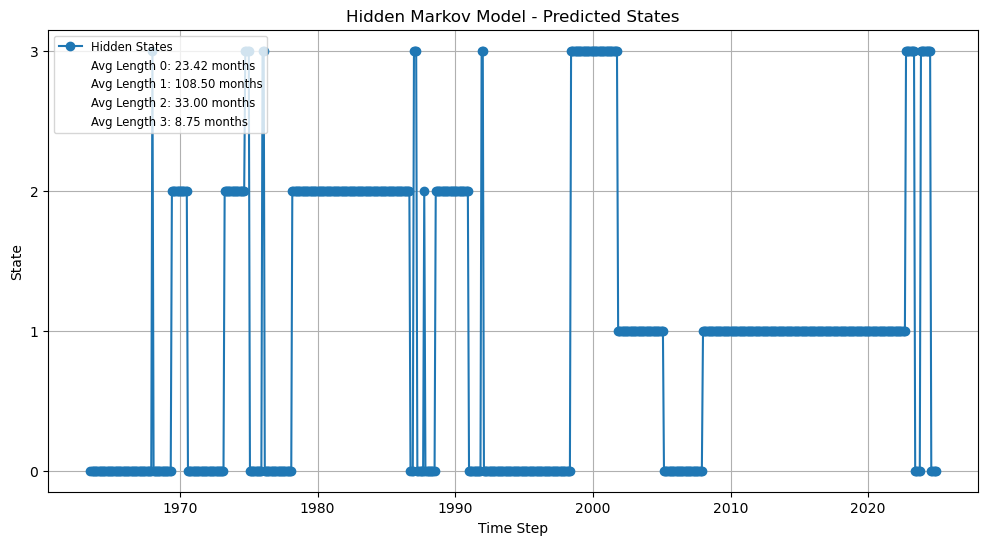

In [275]:
plt.figure(figsize=(12, 6))
plt.plot(data_fama_french.index, hidden_states, label='Hidden States', marker='o', linestyle='-')
plt.title('Hidden Markov Model - Predicted States')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.yticks(np.arange(h.n_components))
for state, lengths in average_lengths.items():
    plt.plot([], [], ' ', label=f'Avg Length {state}: {lengths:.2f} months')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.show()


In [270]:
#TODO sortiraj stanja po low-medium-high, napravi opet graf, ispiši srednju vrijednost trajanja svakog stanja
#TODO dodaj plot transition matrix